In [1]:
import random
from   os                import path
from   datetime          import datetime
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import mplfinance        as mpf

from sklearn.preprocessing                    import MinMaxScaler
from ydata_synthetic.synthesizers             import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries  import TimeGAN

#np.random.seed(0)

In [2]:
asset = "btcusdt".upper()

dollar_amount = 120000000
df = pd.read_csv(f"./data/{asset}/{asset}-dollarbar-{int(dollar_amount)}.csv", parse_dates=True, index_col="timestamp")

df

,Open,High,Low,Close,Volume,Dollar
timestamp,,,,,,
2018-01-12 11:16:00,13180.10,13980.08,12580.00,13980.08,8910.828190,1.200448e+08
2018-01-13 01:30:00,14013.60,14190.68,13222.00,14088.00,8759.884428,1.200123e+08
2018-01-13 16:54:00,14134.79,14579.98,13830.07,14163.96,8474.617266,1.201859e+08
2018-01-14 11:31:00,14185.00,14339.37,13200.01,13200.01,8696.937808,1.203631e+08
2018-01-14 20:11:00,13249.99,13421.26,12585.00,13199.00,9215.081236,1.202213e+08
...,...,...,...,...,...,...
2022-09-10 06:39:00,21577.51,21582.18,21480.40,21512.67,5736.506680,1.234292e+08
2022-09-10 07:09:00,21507.67,21551.78,21474.05,21531.64,5841.188330,1.256675e+08
2022-09-10 07:41:00,21537.66,21537.66,21433.71,21433.71,5758.000860,1.236914e+08


<AxesSubplot:xlabel='timestamp'>

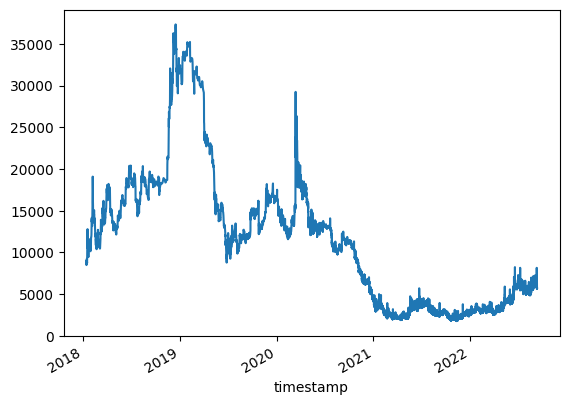

In [3]:
df['Volume'].plot()

<AxesSubplot:xlabel='timestamp'>

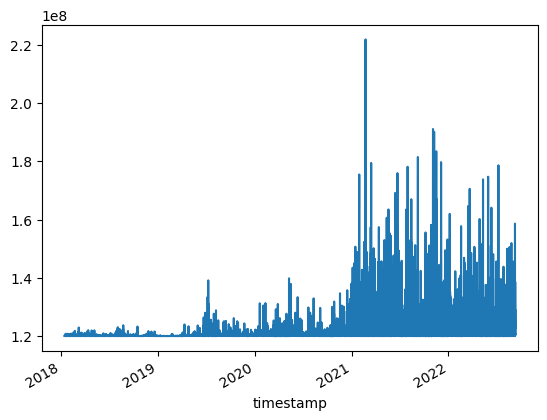

In [4]:
df['Dollar'].plot()

In [5]:
df['dt'     ] = pd.to_datetime(df.index,  unit='s', origin='unix').astype(np.int64)
df['dt_diff'] = df['dt'] - df['dt'].shift(1)

In [6]:
df.dropna(inplace=True)

df

,Open,High,Low,Close,Volume,Dollar,dt,dt_diff
timestamp,,,,,,,,
2018-01-13 01:30:00,14013.60,14190.68,13222.00,14088.00,8759.884428,1.200123e+08,1515807000000000000,5.124000e+13
2018-01-13 16:54:00,14134.79,14579.98,13830.07,14163.96,8474.617266,1.201859e+08,1515862440000000000,5.544000e+13
2018-01-14 11:31:00,14185.00,14339.37,13200.01,13200.01,8696.937808,1.203631e+08,1515929460000000000,6.702000e+13
2018-01-14 20:11:00,13249.99,13421.26,12585.00,13199.00,9215.081236,1.202213e+08,1515960660000000000,3.120000e+13
2018-01-15 12:09:00,13255.00,13730.01,13129.99,13566.59,8917.227895,1.201835e+08,1516018140000000000,5.748000e+13
...,...,...,...,...,...,...,...,...
2022-09-10 06:39:00,21577.51,21582.18,21480.40,21512.67,5736.506680,1.234292e+08,1662791940000000000,1.620000e+12
2022-09-10 07:09:00,21507.67,21551.78,21474.05,21531.64,5841.188330,1.256675e+08,1662793740000000000,1.800000e+12
2022-09-10 07:41:00,21537.66,21537.66,21433.71,21433.71,5758.000860,1.236914e+08,1662795660000000000,1.920000e+12


<AxesSubplot:xlabel='timestamp'>

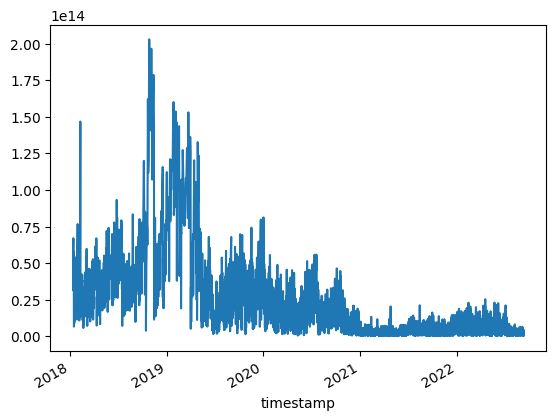

In [7]:
df['dt_diff'].plot()

In [8]:
def real_data_loading(data: np.array, seq_len):
    ori_data = data[::-1]
    scaler   = MinMaxScaler().fit(ori_data)
    ori_data = scaler.transform(ori_data)

    # Preprocess the dataset
    temp_data = []
    # Cut data by sequence length
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    # Mix the datasets (to make it similar to i.i.d)
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])

    return data, scaler

In [9]:
seq_len = 300

columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'dt_diff']
temp_processed, data_scaler = real_data_loading(data=df[columns].values, seq_len=seq_len)

In [10]:
data_scaler

MinMaxScaler()

In [11]:
temp_processed[0].shape

(300, 6)

In [12]:
#Specific to TimeGANs

n_feature     = 6  # ohlcvd
hidden_dim    = 24
gamma         = 1

noise_dim     = 32
dim           = 128
batch_size    = 128

log_step      = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size = batch_size,
                           lr         = learning_rate,
                           noise_dim  = noise_dim,
                           layers_dim = dim)

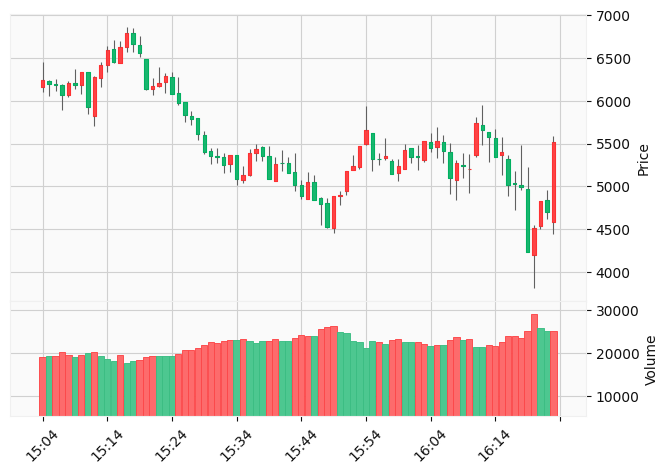

In [24]:
# Real Dollar Bars
random_idx    = np.random.randint(len(temp_processed))

scaled_data   = temp_processed[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:80], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

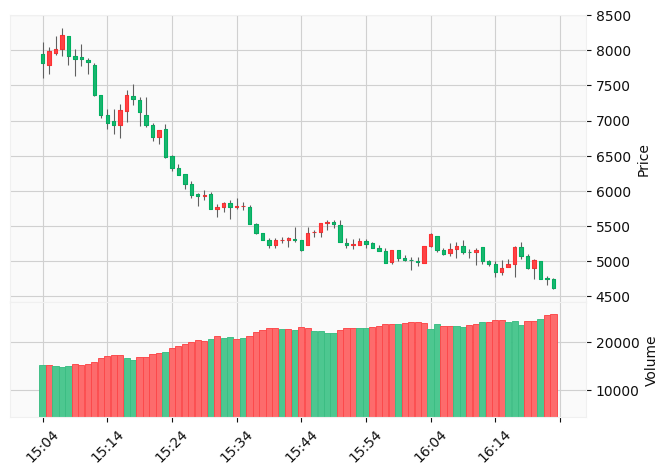

In [26]:
# Real Dollar Bars
random_idx    = np.random.randint(len(temp_processed))

scaled_data   = temp_processed[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:80], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

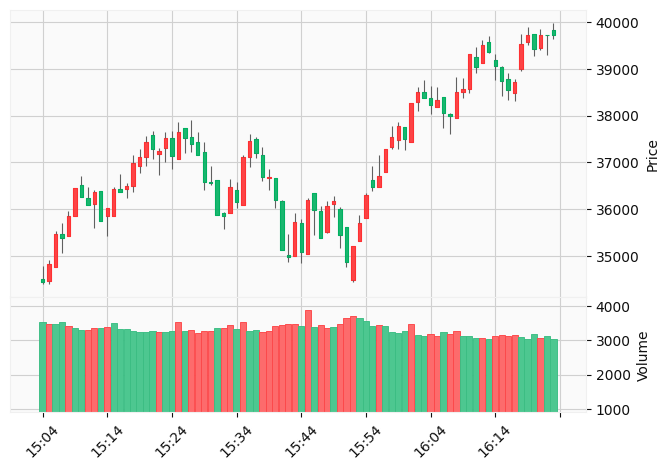

In [27]:
# Real Dollar Bars
random_idx    = np.random.randint(len(temp_processed))

scaled_data   = temp_processed[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:80], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

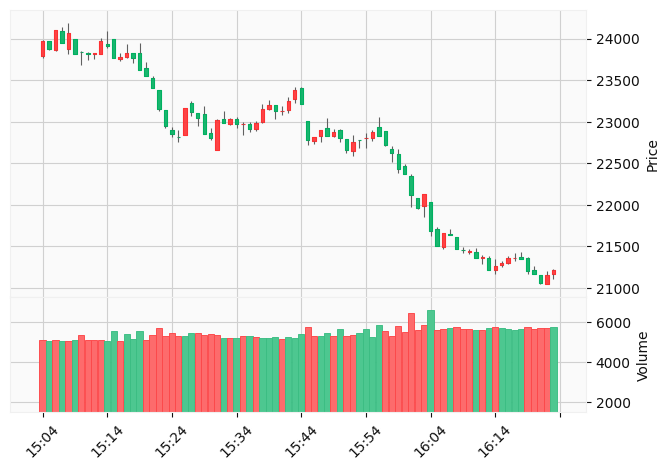

In [28]:
# Real Dollar Bars
random_idx    = np.random.randint(len(temp_processed))

scaled_data   = temp_processed[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:80], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

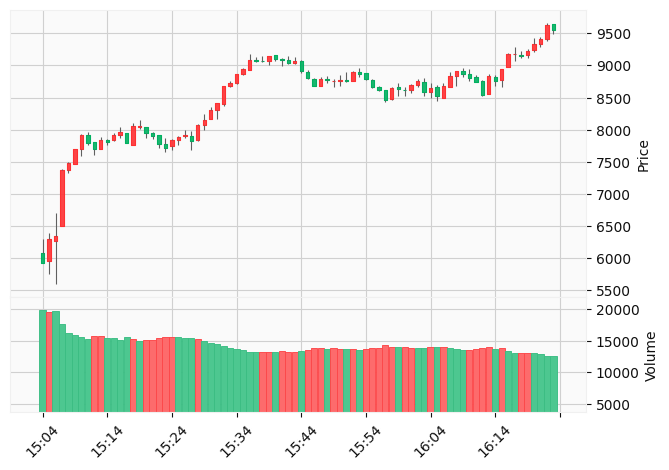

In [29]:
# Real Dollar Bars
random_idx    = np.random.randint(len(temp_processed))

scaled_data   = temp_processed[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:80], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

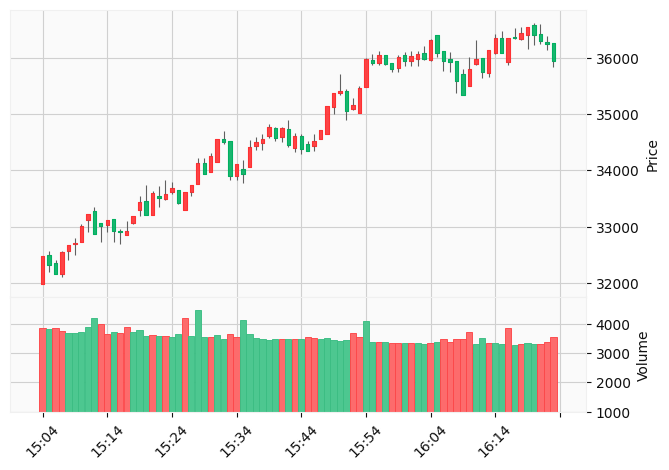

In [30]:
# Real Dollar Bars
random_idx    = np.random.randint(len(temp_processed))

scaled_data   = temp_processed[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:80], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

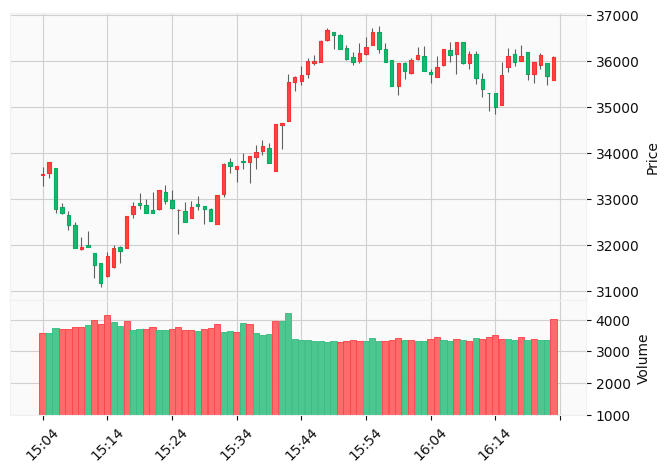

In [31]:
# Real Dollar Bars
random_idx    = np.random.randint(len(temp_processed))

scaled_data   = temp_processed[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:80], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

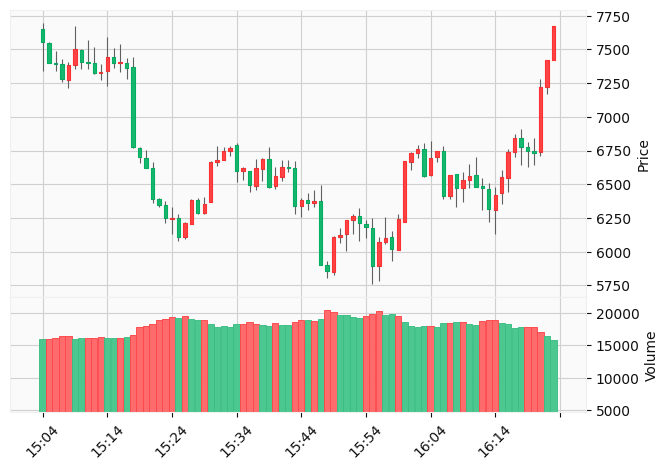

In [32]:
# Real Dollar Bars
random_idx    = np.random.randint(len(temp_processed))

scaled_data   = temp_processed[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:80], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

In [39]:
#Specific to TimeGANs

n_feature     = 6  # ohlcvd
hidden_dim    = 24
gamma         = 1

noise_dim     = 32
dim           = 128
batch_size    = 128

log_step      = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size = batch_size,
                           lr         = learning_rate,
                           noise_dim  = noise_dim,
                           layers_dim = dim)

In [40]:
if path.exists('synthesizer_stock.pkl'):
    synth = TimeGAN.load('synthesizer_stock.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_feature, gamma=1)
    synth.train(temp_processed, train_steps=500)
    synth.save('synthesizer_stock.pkl')

2022-09-22 15:52:32.039107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 15:52:32.044113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 15:52:32.044455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 15:52:32.047223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [42]:
synthetic_data.shape

(128, 300, 6)

In [50]:
synthetic_data = synth.sample(100)

synthetic_data.shape

Synthetic data generation: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


(128, 300, 6)

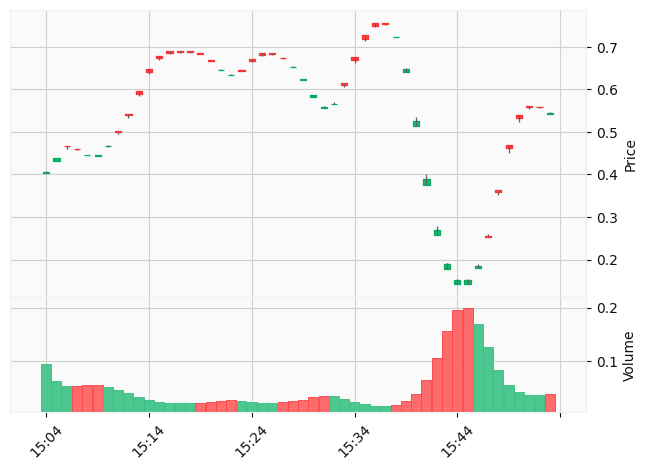

In [51]:
# Chart in scaled form
random_idx = np.random.randint(100)
scaled_data = synthetic_data[random_idx]
temp_df = pd.DataFrame(scaled_data[:50], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'dt_diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

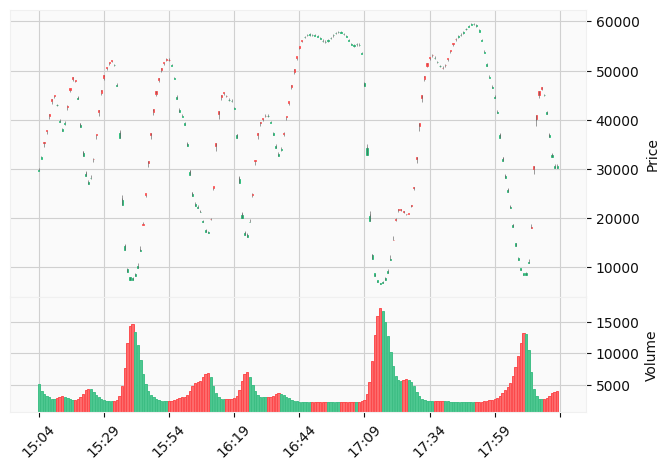

In [52]:
# Descaled chart
random_idx    = np.random.randint(100)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:200], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'dt_diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

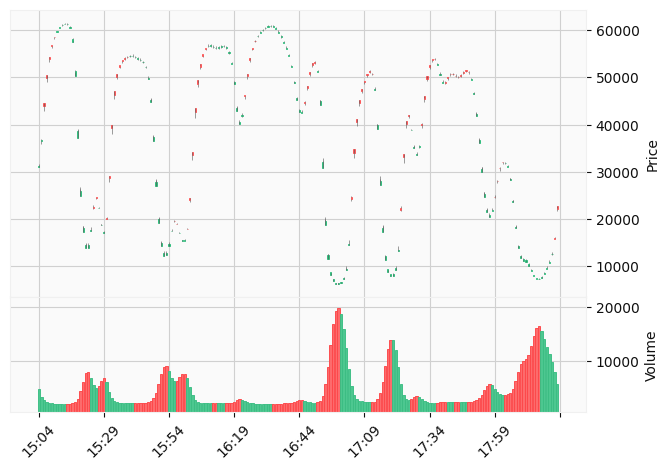

In [53]:
# Descaled chart
random_idx    = np.random.randint(100)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:200], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'dt_diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

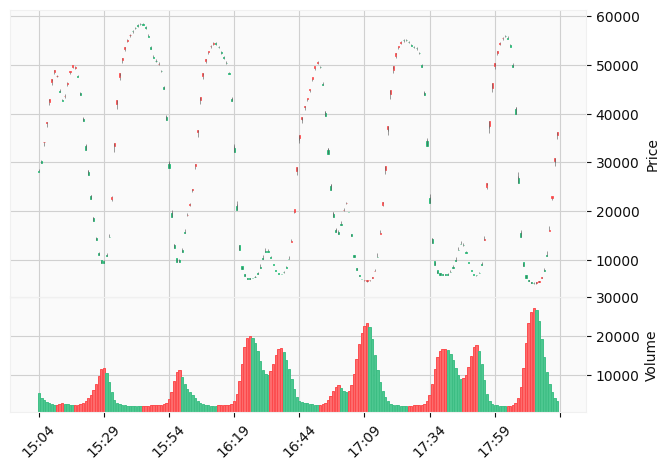

In [54]:
# Descaled chart
random_idx    = np.random.randint(100)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:200], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'dt_diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

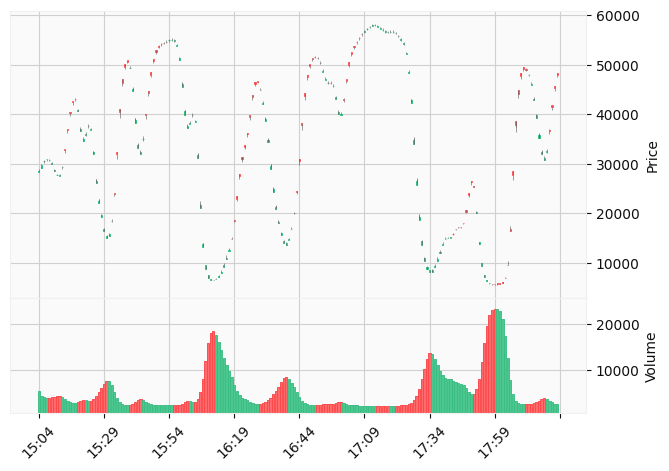

In [55]:
# Descaled chart
random_idx    = np.random.randint(100)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:200], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'dt_diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

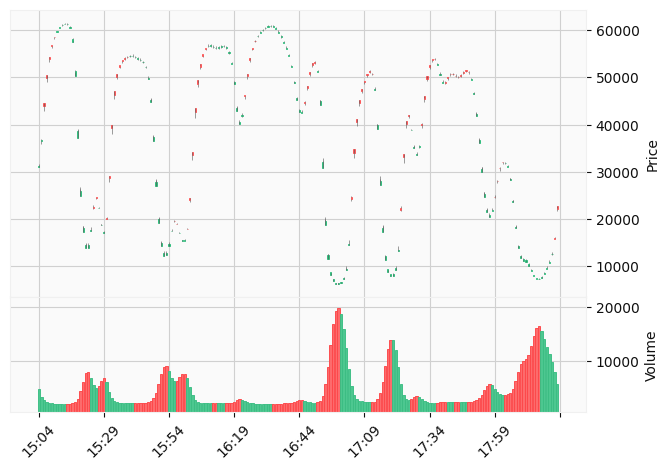

In [56]:
# Descaled chart
random_idx    = np.random.randint(100)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:200], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'dt_diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

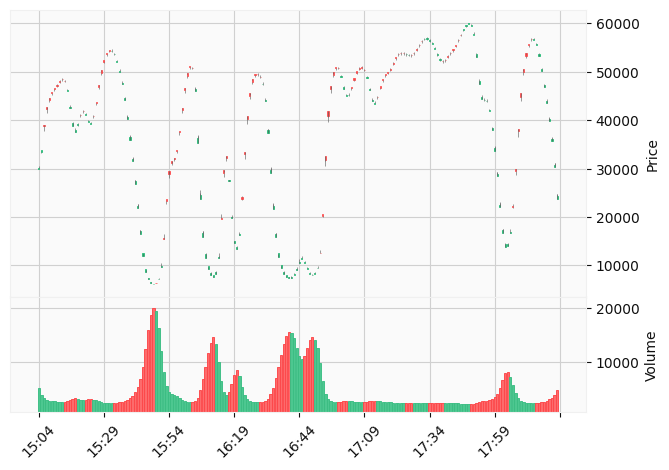

In [57]:
# Descaled chart
random_idx    = np.random.randint(100)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:200], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'dt_diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

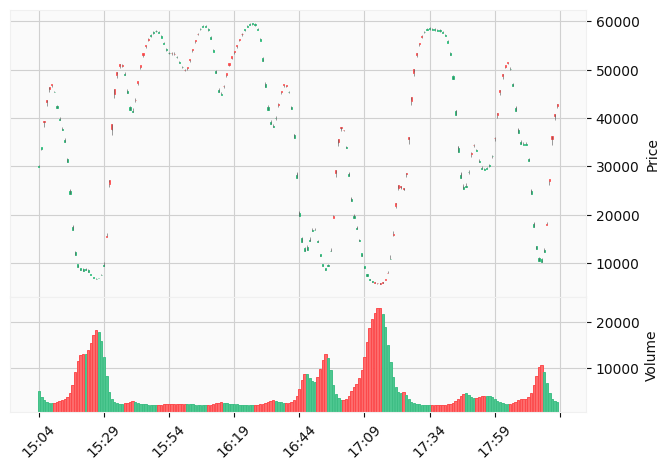

In [58]:
# Descaled chart
random_idx    = np.random.randint(100)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:200], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'dt_diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

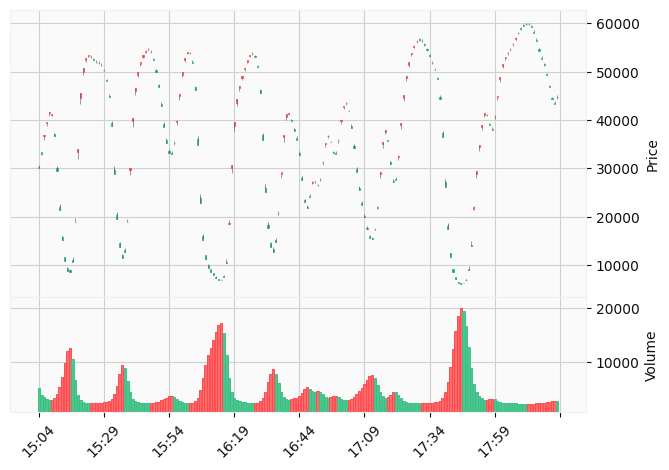

In [59]:
# Descaled chart
random_idx    = np.random.randint(100)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:200], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'dt_diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)

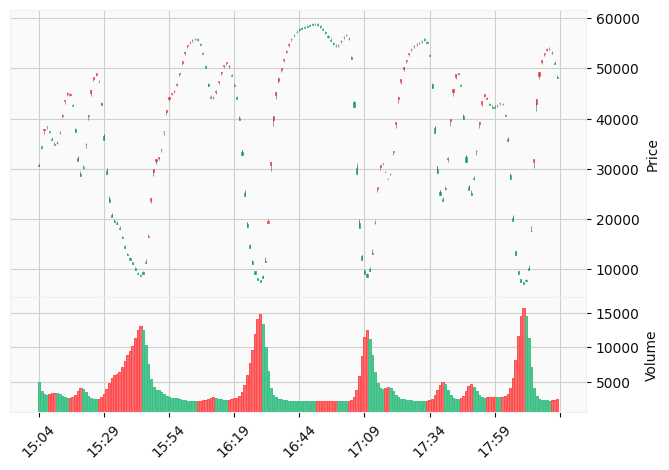

In [60]:
# Descaled chart
random_idx    = np.random.randint(100)
scaled_data   = synthetic_data[random_idx]
descaled_data = data_scaler.inverse_transform(scaled_data)

temp_df = pd.DataFrame(descaled_data[:200], columns=['Open', 'High', 'Low', 'Close', 'Volume', 'dt_diff'])

start_dt = datetime.strptime("6/8/2022 15:04:00.000000", "%d/%m/%Y %H:%M:%S.%f")
temp_df['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(temp_df))]

temp_df = temp_df.set_index(pd.DatetimeIndex(temp_df['datetime']))
temp_df = temp_df.drop(['datetime'], axis=1)

mpf.plot(temp_df, type='candle', style='yahoo', volume=True)